In [1]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image

from network.mynetwork_uu import Unet
from loss.loss import CLIPLoss
from utils.func import get_features,vgg_normalize

import time

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
model = Unet(device).to(device)
# model = Unet().to(device)
cliploss = CLIPLoss(device)
mseloss = torch.nn.MSELoss()
# vgg = torchvision.models.vgg19(pretrained=True).features.to(device)
# for x in vgg.parameters():
#     x.requires_grad = False

topil = transforms.ToPILImage()
topic = transforms.ToTensor()

In [4]:
lr1 = 0.001
lr2 = 0.0003

# lr_fast = 0.0003
# lr_slow = 0.0004

dir_lambda = 500
content_lambda = 150
patch_lambda = 9000
norm_lambda = 0.002
gol_lambda = 300


In [5]:
file_uu = open("neo0.txt", "r")
loss_li = file_uu.readline()
loss_li = [float(x) for x in loss_li.split()]
if not loss_li:
    loss_li = [0]*100

cur_times = int(file_uu.readline())



In [6]:
def train(iteration1, iteration2, pic, source, target):
    input = pic

    # pic_f = get_features(vgg_normalize(pic), vgg)
    # print(model.parameters())
    opt = optim.Adam(model.parameters(), lr=lr1)
    for i in range(iteration1):
        opt.zero_grad()
        neo_pic = model(input)
        loss = mseloss(pic, neo_pic) * 1

        # loss = 0
        # neo_pic_f = get_features(vgg_normalize(neo_pic), vgg)
        # loss += torch.mean((pic_f['conv4_2'] - neo_pic_f['conv4_2']) ** 2)
        # loss += torch.mean((pic_f['conv5_2'] - neo_pic_f['conv5_2']) ** 2)

        loss.backward()
        opt.step()

        with torch.no_grad():
            print("iter:", i + 1, "loss:", loss.item())

        # pil = topil(neo_pic.squeeze(0).cpu())
        # if ((i + 1) % 50) == 0:
        #     pil.save(f"./pic1/{(i + 1) // 50}.jpg")

    neo_pic = model(input)
    pil = topil(neo_pic.squeeze(0).cpu())
    pil.save(f"mid.jpg")


    # torch.save(model,'unet.pth')

    # model = torch.load('unet.pth')

    # pic_f = get_features(vgg_normalize(pic),vgg)

    opt = optim.Adam(model.parameters(), lr=lr2)
    # opt_fast = optim.Adam(model.parameters(), lr=lr_fast)
    # opt_slow = optim.Adam(model.parameters(), lr=lr_slow)
    # opt_loss = optim.Adam(cliploss.parameters(), lr=lr_slow)
    for i in range(iteration2):


        opt.zero_grad()
        # opt_slow.zero_grad()
        # opt_fast.zero_grad()

        neo_pic = model(input)

        dir_loss = 0
        dir_loss += cliploss.forward_dir(pic, source, neo_pic, target)

        gol_loss = 0
        gol_loss += cliploss.forward_gol(pic, source, neo_pic, target)

        content_loss = 0
        # content_loss += mseloss(pic, neo_pic)
        # neo_pic_f = get_features(vgg_normalize(neo_pic), vgg)
        # content_loss += torch.mean((pic_f['conv4_2'] - neo_pic_f['conv4_2']) ** 2)
        # content_loss += torch.mean((pic_f['conv5_2'] - neo_pic_f['conv5_2']) ** 2)

        patch_loss = 0
        # patch_loss += cliploss.forward_patch(pic, source, neo_pic, target)

        norm_loss = 0
        norm_loss += cliploss.forward_prior(pic, source, neo_pic, target)

        loss = dir_loss * dir_lambda + \
               content_loss * content_lambda + \
               patch_loss * patch_lambda + \
               norm_loss * norm_lambda + \
               gol_loss * gol_lambda



        patch_loss_fast,patch_loss_slow = cliploss.forward_patch_sec(pic, source, neo_pic, target)
        patch_loss_fast *= patch_lambda
        patch_loss_slow *= patch_lambda

        for x in model.res2.parameters():
            x.requires_grad = False
        patch_loss_slow.backward(retain_graph=True)
        for x in model.res2.parameters():
            x.requires_grad = True

        for x in model.res.parameters():
            x.requires_grad = False
        for x in model.conv3.parameters():
            x.requires_grad = False
        for x in model.upsample3.parameters():
            x.requires_grad = False
        for x in model.deconv3.parameters():
            x.requires_grad = False
        patch_loss_fast.backward(retain_graph=True)
        for x in model.res.parameters():
            x.requires_grad = True
        for x in model.conv3.parameters():
            x.requires_grad = True
        for x in model.upsample3.parameters():
            x.requires_grad = True
        for x in model.deconv3.parameters():
            x.requires_grad = True

        loss.backward()
        # (loss+patch_loss_fast+patch_loss_slow).backward()


        opt.step()

        # opt_fast.step()
        # opt_slow.step()

        with torch.no_grad():
            loss_li[i]+=(loss+patch_loss_fast+patch_loss_slow).item()

            print("iter:", i + 1, "fast_loss:", patch_loss_fast.item(), "slow_loss:", patch_loss_slow.item())
            print("iter:", i + 1, "loss:", (loss+patch_loss_fast+patch_loss_slow).item())


        # pil = topil(neo_pic.squeeze(0).cpu())
        # if ((i + 1) % 10) == 0:
        #     pil.save(f"./pic2/{(i + 1) // 10}.jpg")

    # return  model(input)
    # neo_pic = model(input)
    # pil = topil(neo_pic.squeeze(0).cpu())
    # # pil.save(f"{source}-{target}.jpg")
    # pil.save(path)



In [7]:
pil = Image.open(f"./source_pic/church.jpeg")
# pil = Image.open(f"resulto.jpg")
ori_size = pil.size[::-1]
pil = transforms.Resize(size=(512, 512), interpolation=Image.BICUBIC)(pil)
pic = topic(pil).unsqueeze(0).to(device)
# pic = torch.ones(1, 3, 512, 512).to(device)
pic.requires_grad = False

C:\Users\win10\AppData\Local\Temp\ipykernel_45928\2685826465.py:4: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  pil = transforms.Resize(size=(512, 512), interpolation=Image.BICUBIC)(pil)


In [8]:
# source = "cat"
source = "photo"
# source = "CG picture"
# source = "happy"
# source = "morning"

# target = "angry"
# target = "pop art"
# target = "man"
# target = "Watercolor Art with Thick Brush"
# target = "Pixar"
# target = "watercolor painting"
# target = "Van Gogh"
# target = "the scream by Edvard Munch"
# target = "Monet"
# target = "cyberpunk 2077"
# target = "oil painting of flowers"
# target = "man with dark black skin and black black hair"
# target = "The great wave off kanagawa by Hokusai"
# target = "fire"
# target = "Chinese Brush Painting of mountains in black and white"
# target = "Expressionism"
# target = "night"
# target = "sketch in black and white"
target = "pop art of night city"
# target = "wall paintings"
# target = "Japanese anime"


path = "result/result.jpg"

In [9]:
start = time.time()
train(100, 100, pic, source, target)
end = time.time()
usetime = end - start
print(f"usetime: {usetime}")

iter: 1 loss: 0.055114686489105225
iter: 2 loss: 0.028696700930595398
iter: 3 loss: 0.016963815316557884
iter: 4 loss: 0.010907700285315514
iter: 5 loss: 0.00791964866220951
iter: 6 loss: 0.006265615578740835
iter: 7 loss: 0.005237500183284283
iter: 8 loss: 0.004563248250633478
iter: 9 loss: 0.004103356972336769
iter: 10 loss: 0.0037516779266297817
iter: 11 loss: 0.0034398548305034637
iter: 12 loss: 0.0031443475745618343
iter: 13 loss: 0.0028667596634477377
iter: 14 loss: 0.002623003674671054
iter: 15 loss: 0.002421941375359893
iter: 16 loss: 0.0022649653255939484
iter: 17 loss: 0.002153267152607441
iter: 18 loss: 0.002082414459437132
iter: 19 loss: 0.0020352760329842567
iter: 20 loss: 0.001987274270504713
iter: 21 loss: 0.0019227139418944716
iter: 22 loss: 0.0018413199577480555
iter: 23 loss: 0.0017517696833238006
iter: 24 loss: 0.0016644082497805357
iter: 25 loss: 0.0015863360604271293
iter: 26 loss: 0.0015218392945826054
iter: 27 loss: 0.001471865689381957
iter: 28 loss: 0.001432948

In [10]:
neo_pic = model(pic)
pil = topil(neo_pic.squeeze(0).cpu())
pil = transforms.Resize(size=ori_size, interpolation=Image.BICUBIC)(pil)
pil.save(path)





C:\Users\win10\AppData\Local\Temp\ipykernel_45928\4189447853.py:3: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  pil = transforms.Resize(size=ori_size, interpolation=Image.BICUBIC)(pil)


In [11]:
with open(file = "neo0.txt", mode = "w") as file:
    for i in loss_li:
        file.write(str(i)+" ")
    file.write("\n")
    file.write(str(cur_times+1))


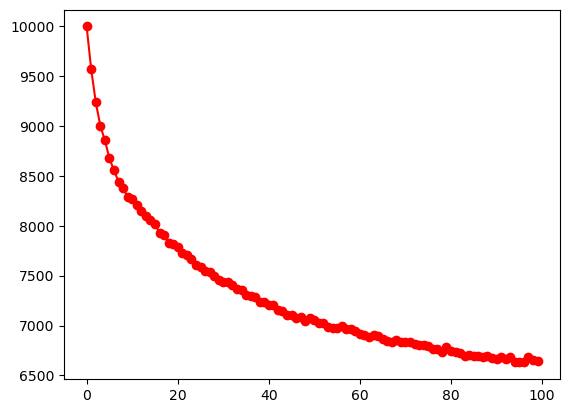

In [12]:
import matplotlib.pyplot as plt

x = [i for i in range(100)]
loss_li = [x/(cur_times+1) for x in loss_li]
plt.plot(x,loss_li,color="red",marker="o")





#